In [52]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import json
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
import glob
from collections import Counter
from astropy.table import Table
plt.rcParams.update({'font.size': 15})

In [59]:
program = "dark_gray"
#program = "bright"
hemisphere = "south"
target_mask = desi_mask["BGS_ANY"]
targetdata = fitsio.read("targets/{}_{}.fits".format(program, hemisphere))
targetdata = np.sort(targetdata, order='TARGETID')

In [60]:
n = len(targetdata)
r = np.random.random(n)
rr = r < 0.001

In [61]:
fba_files = glob.glob("fba_{}_{}/fba-*.fits".format(program, hemisphere))
print(len(fba_files))

3085


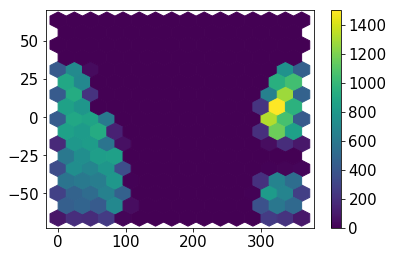

In [62]:
#plt.scatter(, , s=0.1)
plt.hexbin((targetdata['RA'][rr]), targetdata['DEC'][rr], gridsize=15,bins=None)
plt.colorbar()

In [63]:

t_assigned = []
t_avail = []
for fba_file in fba_files:
    fassign = fitsio.read(fba_file, ext="FASSIGN")
    favail = fitsio.read(fba_file, ext="FAVAIL")
    t_assigned.append(fassign["TARGETID"])
    t_avail.append(favail["TARGETID"])


In [64]:
targetid_assigned = np.concatenate(t_assigned)
targetid_available = np.concatenate(t_avail)

In [65]:
targetid_assigned

array([35185359390250757, 35185359390248996, 35185359386055293, ...,
       35185854548807535, 35185854548807509, 35185854548806573])

In [66]:
counter_assigned = Counter(targetid_assigned)

In [67]:
id_assigned = np.array(list(counter_assigned.keys()))
count_assigned = np.array(list(counter_assigned.values()))

ii = np.argsort(id_assigned)
id_assigned = id_assigned[ii]
count_assigned = count_assigned[ii]

is_target = np.isin(id_assigned, targetdata['TARGETID'])
id_assigned = id_assigned[is_target]
count_assigned = count_assigned[is_target]

n_assigned = np.zeros(len(targetdata), dtype=int)

ii = np.isin(targetdata['TARGETID'], id_assigned)
n_assigned[ii] = count_assigned

In [68]:
is_available = np.zeros(len(targetdata), dtype=bool)
id_available = np.isin(targetdata['TARGETID'], targetid_available)
is_available[id_available] = True

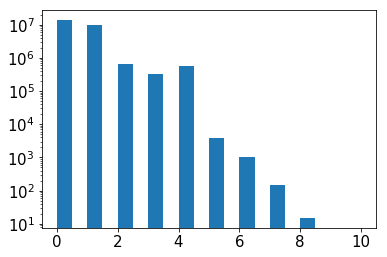

In [69]:
n = plt.hist(n_assigned[is_available], log=True, bins=np.linspace(0,10,21))

In [70]:
types = {'isELG':desi_mask['ELG'],
        'isLRG':desi_mask['LRG'],
        'isQSO':desi_mask['QSO'],
        'isBGS_ANY':desi_mask['BGS_ANY'],
        'isMWS_ANY':desi_mask['MWS_ANY']}

In [71]:
masks = {}
for t, m in zip(types.keys(), types.values()):
    ii = (targetdata['DESI_TARGET']&m)!=0
    print(t, np.count_nonzero(ii))
    masks[t] = ii

isELG 20435492
isLRG 4400531
isQSO 2516906
isBGS_ANY 5440783
isMWS_ANY 15488770


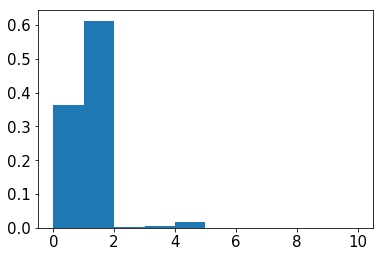

In [72]:
n = plt.hist(n_assigned[masks['isELG']&is_available], log=False, density=True, bins=np.linspace(0,10,11))

In [74]:
targettable = Table(targetdata)

In [75]:
targettable['NUM_OBS']= n_assigned

In [76]:
for m in masks.keys():
    targettable[m] = masks[m]

In [77]:
targettable['AVAIL'] = is_available

In [78]:
targettable[:10]

BRICKNAME,RA,DEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL,NUMOBS_MORE,PRIORITY,OBSCONDITIONS,NUM_OBS,isELG,isLRG,isQSO,isBGS_ANY,isMWS_ANY,AVAIL
bytes8,float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int32,int64,bool,bool,bool,bool,bool,bool
3232m680,323.0575005051967,-67.95464350713019,35184475235156232,2305843026393563136,0,2,2998,0.778839675205824,1,45473,1,2998,7,0,False,False,False,False,True,False
3245m680,324.63560410375914,-68.04834838671904,35184475243544615,2305843009213693952,0,4,1600,0.6947392822910938,1,45454,1,1600,7,0,False,False,False,False,True,False
3252m680,324.98299310162554,-67.88454841379234,35184475247738911,2305843026393563136,0,6,2998,0.20560024113067255,1,45454,1,2998,7,0,False,False,False,False,True,False
3285m680,328.5378704415542,-68.06319901745374,35184475268711027,2305843009213693952,0,4,1600,0.368888153417533,1,45453,1,1600,7,0,False,False,False,False,True,False
3285m680,328.8513167094418,-67.90603147450103,35184475268712633,2305843009213693952,0,4,1600,0.4513391244741477,1,45453,1,1600,7,0,False,False,False,False,True,False
3312m680,331.1070757539721,-68.0872614847164,35184475285488055,2305843026393563136,0,2,2998,0.4530104768346943,1,45458,1,2998,7,0,False,False,False,False,True,False
3325m680,332.69339444806394,-67.95661029772133,35184475293877094,2305843009213693952,0,4,1600,0.6830137974975531,1,45458,1,1600,7,0,False,False,False,False,True,False
3331m680,333.014171789595,-67.92419371665443,35184475298071659,2305843026393563136,0,2,2998,0.331676132031152,1,45457,1,2998,7,0,False,False,False,False,True,False
3371m680,337.01727957820094,-67.97813409428798,35184475323236775,2305843026393563136,0,2,2998,0.026308502688332625,1,45374,1,2998,7,0,False,False,False,False,True,False


In [79]:
targettable.write("fba_summary_{}_{}.fits".format(program, hemisphere), overwrite=True)

In [80]:
summary_south = Table.read("fba_summary_dark_gray_south.fits")

In [81]:
summary_north = Table.read("fba_summary_dark_gray_north.fits")

In [82]:
summary_north

BRICKNAME,RA,DEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL,NUMOBS_MORE,PRIORITY,OBSCONDITIONS,NUM_OBS,isELG,isLRG,isQSO,isBGS_ANY,isMWS_ANY,AVAIL
str8,float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int32,int64,bool,bool,bool,bool,bool,bool
2167m107,216.8464346981716,-10.631225643751602,35185502982242305,2305843009213693952,0,1280,1500,0.45177296197112116,1,44961,1,1500,7,0,False,False,False,False,True,False
2167m107,216.8232802388411,-10.631043231388466,35185502982242310,2305843009213693952,0,1280,1500,0.7516987728498211,1,44961,1,1500,7,0,False,False,False,False,True,False
2167m107,216.63532410918964,-10.62976846023926,35185502982242317,2305843009213693952,0,33,1400,0.30242670477380873,1,44963,1,1400,7,0,False,False,False,False,True,False
2167m107,216.827705060818,-10.626414608342792,35185502982242349,2305843009213693952,0,33,1400,0.2959538896489107,1,44961,1,1400,7,0,False,False,False,False,True,False
2172m107,217.251602945333,-10.63274678933654,35185502990630925,2305843009213693952,0,10240,1500,0.4977574441407342,1,44961,1,1500,7,0,False,False,False,False,True,False
2172m107,217.24612406328052,-10.63117808838864,35185502990630934,2305843009213693952,0,1280,1500,0.6212916243026018,1,44961,1,1500,7,0,False,False,False,False,True,False
2172m107,217.28779297180262,-10.626230187432464,35185502990630948,2305843009213693952,0,10240,1500,0.18904632498315488,1,44961,1,1500,7,0,False,False,False,False,True,False
2172m107,217.28233708653616,-10.6256657575561,35185502990630950,2305843009213693952,0,1280,1500,0.5787504792658833,1,44961,1,1500,7,0,False,False,False,False,True,False
2172m107,217.31980782641133,-10.625185205151293,35185502990630951,2305843009213693952,0,1280,1500,0.13237245099424388,1,44961,1,1500,7,0,False,False,False,False,True,False


6536350


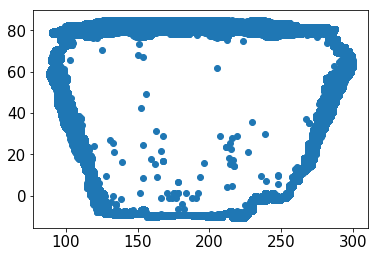

In [83]:
ii = summary_north['AVAIL']==False
print(np.count_nonzero(ii))
plt.scatter(summary_north['RA'][ii], summary_north['DEC'][ii])

6536350


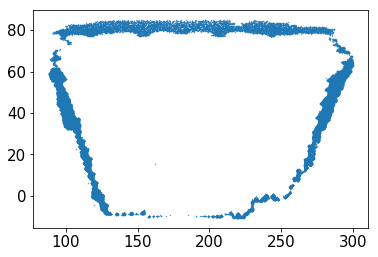

In [87]:
n = len(summary_north)
r = np.random.random(n)
rr = r < 0.01
ii = summary_north['AVAIL']==False
print(np.count_nonzero(ii))
plt.scatter(summary_north['RA'][ii & rr], summary_north['DEC'][ii & rr], s=0.1)